In [2]:
!pip install pytorch-tabnet
!pip install xgboost lightgbm catboost joblib

# config

In [3]:
class CFG:
    
    USE_GPU= False
    test =0.2
    normalize = False#True
    overSampling = True # handling imbalance class
    crossValidate = False#True # Support cross Validation 
    nFold = 5#4 # 8  No remainder  for oversampling 


    USE_XGB = True
    USE_TABNET = True

    # XGBoost
    xgbEstimate = 200 # 250 , 300 
    xgbDepth = 7 #5 #6, low value avoid overfit
    xgbLR = 0.05 # 0.08

    # Tabnet model hyperparameter 
    maxEpochs = 1000
    n_d =32 #8
    n_a = 32 # 8
    n_steps = 5 # 3
    mask_type = "entmax" # "sparsemax"
    learningRate = 1e-3 # 1e-2
    
    trainSeriesParquet = "series_train.parquet"
    testSeriesParquet = "series_test.parquet"
    # rootDir ="/kaggle/input/child-mind-institute-problematic-internet-use/"
    rootDir = "/Users/jiazhiyuan/personal_repos/child-health/data/"
    dataDictionary = rootDir+"data_dictionary.csv"
    trainDataFile= rootDir+"train.csv"
    testDataFile = rootDir+"test.csv"
    samplesub = rootDir+"sample_submission.csv"
    trainSerise1Path = rootDir+"series_train.parquet/id=00115b9f/part-0.parquet"

import os, gc, time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import Markdown
import ctypes
import seaborn as sns
from tqdm import tqdm

import torch
from pytorch_tabnet.tab_model import TabNetClassifier


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, KFold, GridSearchCV, StratifiedKFold,
                                    cross_val_score)
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# over Sample 
from imblearn.over_sampling import SMOTE

from sklearn.metrics import ( mean_absolute_error, 
                             mean_squared_error, 
                             r2_score, 
                             cohen_kappa_score)

from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     GridSearchCV, 
                                     StratifiedKFold)


# import torch
# ML library 
from xgboost import XGBRFRegressor, XGBClassifier# plot_importance, plot_tree
import xgboost
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
from sklearn.ensemble import (RandomForestRegressor,  RandomForestClassifier ,
                              VotingRegressor, VotingClassifier )

# multiple processing lib
from joblib import Parallel , delayed
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    


# 获取传感器信息的统计量名称

In [4]:
trainSerise1 = pd.read_parquet(CFG.trainSerise1Path)
trainSerise1.drop("step", axis=1, inplace=True)
sensorFeature =trainSerise1.columns.to_list()
statFeat = trainSerise1.describe().index.to_list() 
sensorStatCol = []
for sta in statFeat: # start statist row 
    # print(sta)
    for item in sensorFeature:
        # print(item)
        sensorStatCol.append(f"{item}_{sta}")

# 载入数据原始表格，并与传感器数据合并

In [5]:
trainDataDF = pd.read_csv(CFG.trainDataFile)
testDataDF = pd.read_csv(CFG.testDataFile)
submit = pd.read_csv(CFG.samplesub)

In [6]:
%%time

def loadParquetFile(directory, fileName):
    """
    read parquet file 
    """
    path = os.path.join(directory, fileName, "part-0.parquet")
    df = pd.read_parquet(path)
    df.drop("step", axis=1, inplace=True) # drop step column
    statDF = df.describe().values.reshape(-1)
    return statDF, fileName.split("=")[1] # get ids
    

def loadTimeSeriesData(directory):
    """
    input : root direction
    """
#     print("DIR :", directory)
    filesIds = os.listdir(directory) # get list of folder name (files ids)
#     print(filesIds)
    with ThreadPoolExecutor() as executor:
#     with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: loadParquetFile(directory, fname), filesIds), total=len(filesIds)))
#     print(results)
    statistic, ids = zip(*results) # pack into Statistic and Ids 
    # create new dataframe with n statistic sensor data
#     data = pd.DataFrame(statistic, columns=[f"stat_{i}" for i in range(len(statistic[0]))])
    data = pd.DataFrame(statistic, columns=sensorStatCol)
    data["id"] = ids # add ids into dataframe
#     print(data)
    
    return data

trainTSData = loadTimeSeriesData((CFG.rootDir + CFG.trainSeriesParquet))
testTSData = loadTimeSeriesData((CFG.rootDir + CFG.testSeriesParquet))

100%|██████████| 2/2 [00:00<00:00, 14.56it/s]

CPU times: user 3min 43s, sys: 47 s, total: 4min 30s
Wall time: 54.1 s


In [7]:
combinedTrainDF =  pd.merge(trainDataDF, trainTSData, how="left", on='id')
combinedTestDF = pd.merge(testDataDF, testTSData, how="left", on='id')
combinedTrainDF = combinedTrainDF.drop("id", axis=1)
combinedTestDF = combinedTestDF.drop("id", axis=1)

# 数据清洗
- label为null的样本去除
- 缺失的属性用均值等补齐
- 将train表格向test对齐，去除train中test没有的属性
- 将string类别型属性映射到整型

In [8]:
combinedTrainDF = combinedTrainDF.dropna(subset="sii")

columnsTestCategory = []
for col in combinedTestDF.columns:
    if combinedTestDF[col].dtype == "object":
        columnsTestCategory.append(col)
columnsTestNum = []
for col in combinedTestDF.columns:
    if combinedTestDF[col].dtype != "object" and col !="sii":
        columnsTestNum.append(col)
trainCol =columnsTestCategory + columnsTestNum +["sii"]
testCol = columnsTestCategory + columnsTestNum
combinedTrainDF =combinedTrainDF[trainCol]
combinedTestDF = combinedTestDF[testCol]

# fill the Nan (missing) in for category
for c in columnsTestCategory:
    combinedTrainDF[c] = combinedTrainDF[c].fillna('missing') # fill na for missing category
    combinedTestDF[c] = combinedTestDF[c].fillna("missing") 
#  fill the Nan numberic with median value 
for c in columnsTestNum:
    combinedTrainDF[c] = combinedTrainDF[c].fillna(combinedTrainDF[c].median())
    combinedTestDF[c] = combinedTestDF[c].fillna(combinedTestDF[c].median())

# define Category dictionary for encode 
catDic = {"missing": 0, "Spring": 1, "Summer": 2, "Fall": 3, "Winter" : 4}
for c in columnsTestCategory:
    combinedTrainDF[c] = combinedTrainDF[c].map(catDic)
    combinedTestDF[c] =combinedTestDF[c].map(catDic)

combinedTrainDF['Physical-Weight'].replace(0, combinedTrainDF['Physical-Weight'].median() , 
                                           inplace=True )
combinedTrainDF["Physical-BMI"].replace(0, combinedTrainDF["Physical-BMI"].median() , inplace=True)

/var/folders/bt/t9j0x49157j0mmn3fmdnq04r0000gn/T/ipykernel_25929/2411355846.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combinedTrainDF['Physical-Weight'].replace(0, combinedTrainDF['Physical-Weight'].median() ,
/var/folders/bt/t9j0x49157j0mmn3fmdnq04r0000gn/T/ipykernel_25929/2411355846.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

# 特征工程
构造复杂的健康分析函数

In [9]:
def getBMIInfo(df):
    """
    classify Weight category by BMI reference from World Health Organization  
    """
    # print(df)
    bmi = df["Physical-BMI"]
    age = df["Basic_Demos-Age"]
    gender = df["Basic_Demos-Sex"]
    bodyweightClass = 0
    if df["Basic_Demos-Sex"] == 0: # for female
        if age < 8 :
            adaptThreshold1 = 12.0
            adaptThreshold2 = 13.0
            adaptThreshold3 = 17.7
            adaptThreshold4 = 0.5*(age-5) + 19.0 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
            
        elif age < 15:
            # apply linear regression 
            adaptThreshold1 = 0.357 * (age-8) + 12.0
            adaptThreshold2 = 0.429 * (age-8) + 13.0
            adaptThreshold3 = 0.828 * (age-8) + 17.7
            adaptThreshold4 = 1.1*(age-8) + 20.5 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        
        elif age < 19:
            # apply linear regression 
            adaptThreshold1 = 14.7
            adaptThreshold2 = 16.5
            adaptThreshold3 = 0.5 * (age-15) + 23.5
            adaptThreshold4 = 0.325 *(age-15) + 28.2 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        else: 
            #use adult
            if bmi < 18.5: 
                bodyweightClass = 0 # thiness 
            elif bmi < 24.9:
                bodyweightClass = 2 # noraml 
            elif bmi < 29.9:
                 bodyweightClass = 3 # Overweight 
            else:
                bodyweightClass = 4 # Obesity

            return bodyweightClass


    else: # for male
        if age < 8 :
            adaptThreshold1 = 12.5
            adaptThreshold2 = 13.2
            adaptThreshold3 = 0.266 *(age-5) + 16.7
            adaptThreshold4 = 0.5*(age-5) + 18.2 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
            
        elif age < 15:
            # apply linear regression 
            adaptThreshold1 = 0.314 * (age-8) + 12.5
            adaptThreshold2 = 0.4 * (age-8) + 13.2
            adaptThreshold3 = 0.742 * (age-8) + 17.5
            adaptThreshold4 = 1.04 *(age-8) + 19.7 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        
        elif age < 19:
            # apply linear regression 
            adaptThreshold1 = 15.7
            adaptThreshold2 = 0.375 * (age-15) + 16.0
            adaptThreshold3 = 0.7 * (age-15) + 22.7
            adaptThreshold4 = 0.675 *(age-15) + 27.0
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        else: 
            #use adult
            if bmi < 18.5: 
                bodyweightClass = 0 # thiness 
            elif bmi < 24.9:
                bodyweightClass = 2 # noraml 
            elif bmi < 29.9:
                 bodyweightClass = 3 # Overweight 
            else:
                bodyweightClass = 4 # Obesity
            return bodyweightClass
def getWaistHeightInfo(df):
    age = df["Basic_Demos-Age"]
    gender = df["Basic_Demos-Sex"]
    ratio = df["Physical-Waist_Circumference"] / df["Physical-Height"]
    ratioClass = 0
    if age < 15:
        if ratio < 0.34:
            ratioClass =0 # Extremely Slim
        elif ratio < 0.45:
            ratioClass  = 1 # slim
        elif ratio < 0.51:
            ratioClass = 2 # Healthy
        elif ratio < 0.63:
            ratioClass = 3 # over weight
        else:
            ratioClass = 5 # Obese
        return ratioClass 

    else : # for adult 
        if gender == 0: # for female
            if ratio < 0.34:
                ratioClass =0 # Extremely Slim
            elif ratio < 0.41:
                ratioClass  = 1 # slim
            elif ratio < 0.48:
                ratioClass = 2 # Healthy
            elif ratio < 0.53:
                ratioClass = 3 # over weight
            elif ratio < 0.57:
                ratioClass = 4 # Very Overweight
            else:
                ratioClass = 5 # Obese
            return ratioClass
        else : # for male
            if ratio < 0.34:
                ratioClass =0 # Extremely Slim
            elif ratio < 0.42:
                ratioClass  = 1 # slim
            elif ratio < 0.52:
                ratioClass = 2 # Healthy
            elif ratio < 0.57:
                ratioClass = 3 # over weight
            elif ratio < 0.62:
                ratioClass = 4 # Very Overweight
            else:
                ratioClass = 5 # Obese
            return ratioClass
def getBodyFatPercentInfo(df):
    """
    classify the user health status by body fat percentage
    """
    gender = df["Basic_Demos-Sex"]
    fatPercent = df["BIA-BIA_Fat"]
    fatclass =0
    if gender == 0: # for female
        if fatPercent < 13:  
            fatclass = 0 # Essential Fat
        elif fatPercent < 20:
            fatclass = 1 # Athletes
        elif fatPercent < 24:
            fatclass = 2 # Fitness
        elif fatPercent < 31:
            fatclass = 3 # acceptable 
        else:
            fatclass = 4 # acceptable 
        return fatclass
    else: # for male
        if fatPercent < 5:  
            fatclass = 0 # Essential Fat
        elif fatPercent < 13:
            fatclass = 1 # Athletes
        elif fatPercent < 17:
            fatclass = 2 # Fitness
        elif fatPercent < 24:
            fatclass = 3 # acceptable 
        else:
            fatclass = 4 # acceptable
        return fatclass
def featureEngineering(df):
    df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
    df["BMI-Classify"]= df.apply(getBMIInfo, axis=1)
    df["Waist-Height-Ratio"] = df["Physical-Waist_Circumference"] / df["Physical-Height"]
    df["Waist-Height-Ratio-Classify"] = df.apply(getWaistHeightInfo, axis=1) 
    df['Internet-Hours-Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI-Internet-Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df["FATPercent-Classify"]= df.apply(getBodyFatPercentInfo, axis= 1)
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat'] #  
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['BMR_Weight'] =df['BMR_Weight'].fillna(0)
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['DEE_Weight'] = df['DEE_Weight'].fillna(0)
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Feature 3
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    
    return df
combinedTestDF= featureEngineering(combinedTestDF)
combinedTrainDF = featureEngineering(combinedTrainDF)
trainCol = combinedTrainDF.columns.tolist()    
testCol = combinedTestDF.columns.tolist()    

/var/folders/bt/t9j0x49157j0mmn3fmdnq04r0000gn/T/ipykernel_25929/3385064183.py:226: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
/var/folders/bt/t9j0x49157j0mmn3fmdnq04r0000gn/T/ipykernel_25929/3385064183.py:227: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["BMI-Classify"]= df.apply(getBMIInfo, axis=1)
/var/folders/bt/t9j0x49157j0mmn3fmdnq04r0000gn/T/ipykernel_25929/3385064183.py:228: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

# XFeature, yLabel

In [10]:
xFeature = combinedTrainDF.drop("sii", axis=1)
yLabel = combinedTrainDF["sii"]

# 数据不均衡，过采样

<Axes: title={'center': 'sii target catergory Distribution'}, xlabel='sii'>

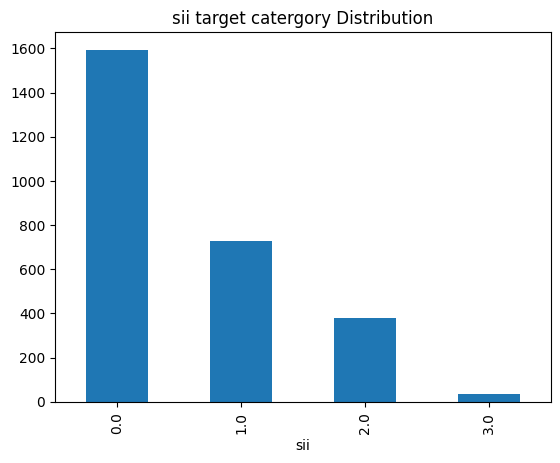

In [11]:
combinedTrainDF["sii"].value_counts().plot(kind="bar", title="sii target catergory Distribution")

In [12]:
# Handling imbalance with SMOTE
if CFG.overSampling:
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(xFeature, yLabel)
    print(len(X_resampled))
    xFeature = X_resampled
    yLabel = y_resampled

6376


/Users/jiazhiyuan/miniconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# 正则化 normalize

In [13]:
from sklearn.utils import compute_sample_weight, class_weight
# scale 
if CFG.normalize:
    scale = StandardScaler()
    scaledXFeature = scale.fit_transform(xFeature)
    xFeature = scaledXFeature
    scaledTestDF    = scale.fit_transform(combinedTestDF)
    combinedTestDF = scaledTestDF

In [14]:
if CFG.crossValidate:
    straKFold = StratifiedKFold(n_splits=CFG.nFold, random_state=42, shuffle=True)
else:
    X_train, X_test, y_train, y_test = train_test_split(xFeature, yLabel, test_size=CFG.test, 
                                                    random_state=42, stratify=yLabel)
    # random_state设置为固定值，让每次划分train、test dataset能一致，结果可重复
    # stratify 划分train、test的依据是按照yLabel的比例，避免样本不均衡在train、test之间发生
    print(X_train.shape)
    print(X_test.shape)  
    print(y_train.shape)
    print(y_test.shape)
    # Compute sample_weight using compute_sample_weight
    sampleWeight = compute_sample_weight('balanced', y_train)
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train)
    print(classes_weights)
    print(len(sampleWeight))

(5100, 173)
(1276, 173)
(5100,)
(1276,)
[1. 1. 1. ... 1. 1. 1.]
5100


# 初始化模型

In [15]:
# XGBoost parameters
if device.type == "cuda":
    XGBparams = {
    'learning_rate': CFG.xgbLR, #0.05 #0.08, #0.01,#0.05,
    'max_depth': CFG.xgbDepth,  #5, #7, #6, low value avoid overfit
    'n_estimators':  CFG.xgbEstimate, # large number lead to overfit, small number lead to underfit
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda'
    }


else: # cpu base
     XGBparams = {
    'learning_rate': CFG.xgbLR, # 0.05 #0.08,#0.01, #0.05,
    'max_depth': CFG.xgbDepth, #7, #6, low value avoid overfit
    'n_estimators': CFG.xgbEstimate, #300, #200,  # large number lead to overfit, small number lead to underfit
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cpu'
    }
# xgb = XGBRFRegressor(**XGBparams ,  verbose=-1)
if CFG.crossValidate:
    xgb = XGBClassifier(**XGBparams ,  verbose=1, objective='multi:softmax', 
                    num_class=3)
    tabNet = TabNetClassifier(
             n_d=CFG.n_d, n_a=CFG.n_a, n_steps=CFG.n_steps,
                        optimizer_params=dict(lr=CFG.learningRate),
                        optimizer_fn=torch.optim.Adam,
                        scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type= CFG.mask_type, #'entmax' # "sparsemax"
        )
else:
    xgb = XGBClassifier(**XGBparams ,  verbose=1, objective='multi:softmax', 
                    num_class=3, sample_weight=sampleWeight)

    tabNet = TabNetClassifier(
             n_d=CFG.n_d, n_a=CFG.n_a, n_steps=CFG.n_steps,
                        optimizer_params=dict(lr=CFG.learningRate),
                        optimizer_fn=torch.optim.Adam,
                        scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type= CFG.mask_type, #'entmax' # "sparsemax"
        )



/Users/jiazhiyuan/miniconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [16]:
xgb.get_params()

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'verbose': 1,
 'num_class': 3,
 'sample_weight': array([1., 1., 1., ..., 1

In [17]:
lbg= LGBMClassifier()
lbg

LGBMClassifier()

In [18]:
def plotConfustionMatrix(actualVal, predictVal, modelName, trainORVal="Training"):
    CM = confusion_matrix(actualVal, predictVal)
    classifyReport =  classification_report(actualVal, predictVal)
    classifyReportDF =  classification_report(actualVal, predictVal, output_dict=True)
    print(f"\n\rClassification Report For {modelName} {trainORVal}:\n\r", classifyReport)
    cmd =ConfusionMatrixDisplay(CM)
    cmd.plot()
    plt.title(f"Confusion Matrix for {modelName} {trainORVal}")
    plt.show()
    return classifyReportDF
def plotKappa(trainKappa, valKappa, modelName):
    kFoldList = [item for item in range(1, len(trainKappa) + 1)]
    plt.figure(figsize=(6, 4))
    plt.plot(kFoldList, trainKappa, label='Training  Kappa')
    plt.plot(kFoldList, valKappa, label='Validation Kappa')
    plt.title(f'{modelName} Kappa (Training/Validation)')
    plt.xlabel('K-Fold')
    plt.ylabel('Kappa')
    plt.legend()
    plt.show()

: 

# 训练模型

In [19]:
# 逐步看训练和输出
xgb.fit(X_train, y_train)

In [ ]:
modelHistory= {}
def trainValFunc(model , modelName):
    trainKappaHist =[]
    valKappaHist = []
    trainClassReportHist =[]
    valClassReportHist =[]
    if CFG.crossValidate:
        for i, (trainIdx, valIdx) in tqdm(enumerate(straKFold.split(xFeature, yLabel))):
            print(f"K-Fold: {i} ")
#             print(f"Train Idx : {trainIdx}")
#             print(f"Validate Idx: {valIdx}")
            # Set extract X_Train , X_test , y_train, y_test new split dataset 
            if CFG.normalize:
                X_train = xFeature[trainIdx, :] # filter/select train idx for X_Train
                X_test = xFeature[valIdx, :] # filter/select validation idx for X_Train
                y_train = yLabel[trainIdx]
                y_test  = yLabel[valIdx]
            else:
                X_train = xFeature.iloc[trainIdx, :] # filter/select train idx for X_Train
                X_test = xFeature.iloc[valIdx, :] # filter/select validation idx for X_Train
                y_train = yLabel.iloc[trainIdx]
                y_test  = yLabel.iloc[valIdx]
            # train model
            model.fit(X_train, y_train, verbose=True)
            # predict train dataset 
            yTrainPredict = model.predict(X_train)
#             print(yTrainPredict)
            yValPredict = model.predict(X_test)
#             print(yValPredict)
            trainClassifyReport = plotConfustionMatrix(y_train, yTrainPredict, 
                                                       modelName, trainORVal="Training")
            trainClassReportHist.append(trainClassifyReport)
            
            valClassifyReport = plotConfustionMatrix(y_test, yValPredict, 
                                                       modelName, trainORVal="Validation")
            valClassReportHist.append(valClassifyReport)
#             print(trainClassifyReport)
#             print(valClassifyReport)
            trainKappa = cohen_kappa_score(y_train, yTrainPredict)
            trainKappaHist.append(trainKappa)
            print(f"Training cohen Kappa score: {trainKappa}")
            valKappa = cohen_kappa_score(y_test, yValPredict)
            valKappaHist.append(valKappa)
            print(f"Val cohen Kappa score: {valKappa}")
            
        
            
        #store is Model History
        modelHistory[modelName] = {
            "k_Fold": CFG.nFold,
            "train_classify_report" : trainClassReportHist,
            "val_calssify_report": valClassReportHist,
            "train_kappa_score" : trainKappaHist,
            "val_kappa_score": valKappaHist
        }        
    else:
        # Train model
        model.fit(X_train, y_train)
        # Train dateset prediction 
        yTrainPredict = model.predict(X_train)
#         print(yTrainPredict)
        yValPredict = model.predict(X_test)
#         print(yValPredict)
        trainClassifyReport = plotConfustionMatrix(y_train, yTrainPredict, 
                                                       modelName, trainORVal="Training")
        trainClassReportHist.append(trainClassifyReport)
        valClassifyReport = plotConfustionMatrix(y_test, yValPredict, 
                                                       modelName, trainORVal="Validation")
        valClassReportHist.append(valClassifyReport)
#         print(trainClassifyReport)
#         print(valClassifyReport)
        trainKappa = cohen_kappa_score(y_train, yTrainPredict)
        trainKappaHist.append(trainKappa)
        print(f"Training cohen Kappa score: {trainKappa}")
        valKappa = cohen_kappa_score(y_test, yValPredict)
        print(f"Val cohen Kappa score: {valKappa}")
        valKappaHist.append(valKappa)
        
        #store is Model History
        modelHistory[modelName] = {
            "train_classify_report" : trainClassReportHist,
            "val_calssify_report": valClassReportHist,
            "train_kappa_score" : trainKappaHist,
            "val_kappa_score": valKappaHist
        }